In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
neo_df = pd.read_csv('neo_v2.csv')

In [3]:
neo_df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
neo_df.drop(columns=['id', 'name', 'orbiting_body', 'sentry_object'], inplace=True)
num_feats = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']

In [5]:
neo_df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


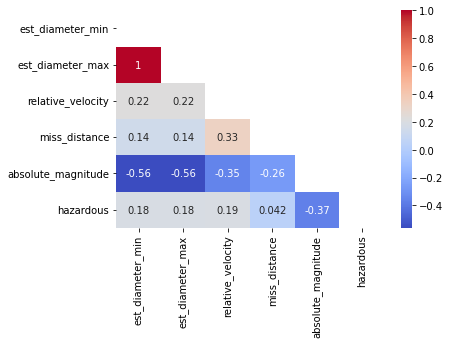

In [6]:
corr = neo_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True);

In [7]:
num_neo_df = neo_df.loc[:, num_feats]

In [8]:
skewness = {feat: num_neo_df[feat].skew() for feat in num_neo_df.columns}
skewness

{'est_diameter_min': 41.13995194872109,
 'est_diameter_max': 41.139951948962064,
 'relative_velocity': 0.9051249321533844,
 'miss_distance': -0.04270598169888327,
 'absolute_magnitude': -0.13741956613464948}

In [9]:
num_neo_df['est_diameter_min'] = np.log(num_neo_df['est_diameter_min'])
num_neo_df['est_diameter_max'] = np.log(num_neo_df['est_diameter_max'])
num_neo_df['relative_velocity'] = np.sqrt(num_neo_df['relative_velocity'])

In [10]:
skewness = {feat: num_neo_df[feat].skew() for feat in num_neo_df.columns}
skewness

{'est_diameter_min': 0.13741956583201068,
 'est_diameter_max': 0.1374195658374031,
 'relative_velocity': 0.1960586412667333,
 'miss_distance': -0.04270598169888327,
 'absolute_magnitude': -0.13741956613464948}

In [11]:
num_neo_df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.180880,0.985598,116.487120,5.483974e+07,16.73
1,-1.325011,-0.520292,271.272421,6.143813e+07,20.00
2,-0.325689,0.479030,338.021733,4.979872e+07,17.83
3,-2.338149,-1.533430,157.366779,2.543497e+07,22.20
4,-1.366458,-0.561739,206.731066,4.627557e+07,20.09


In [12]:
X, y = num_neo_df, neo_df['hazardous']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=4, test_size=0.25)

In [13]:
pipeline_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier())])
pipeline_lr = Pipeline([('scaler', StandardScaler()), ('rfc', LogisticRegression())])
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('rfc', KNeighborsClassifier())])

In [14]:
pipeline_rfc.fit(X_train, y_train);
pipeline_lr.fit(X_train, y_train);
pipeline_knn.fit(X_train, y_train);

In [15]:
rfc_score = pipeline_rfc.score(X_test, y_test)
lr_score = pipeline_lr.score(X_test, y_test)
knn_score = pipeline_knn.score(X_test, y_test)
model_dict = {str(rfc_score): 'RandomForest', str(lr_score): 'LogisticRegression', 
                  str(knn_score): 'KNearestNeighbor'}
print(f'Best model according to accuracy score is {model_dict.get(str(max(rfc_score, lr_score, knn_score)))} with accuracy score {max(rfc_score, lr_score, knn_score) * 100:.2f}%')

Best model according to accuracy score is RandomForest with accuracy score 91.66%


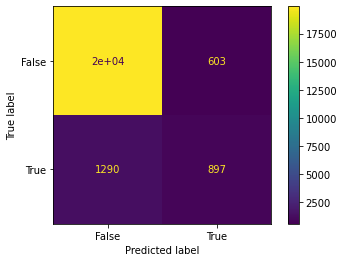

In [16]:
cm_rfc = confusion_matrix(y_test, pipeline_rfc.predict(X_test), labels=pipeline_rfc.classes_)
disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                               display_labels=pipeline_rfc.classes_)
disp_rfc.plot();

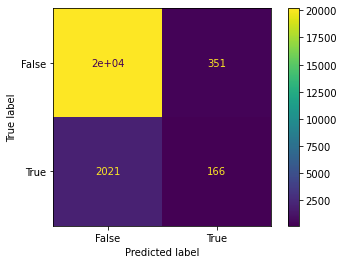

In [17]:
cm_lr = confusion_matrix(y_test, pipeline_lr.predict(X_test), labels=pipeline_lr.classes_)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                               display_labels=pipeline_lr.classes_)
disp_lr.plot();

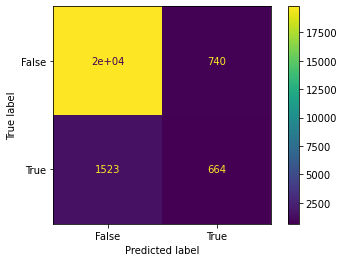

In [18]:
cm_knn = confusion_matrix(y_test, pipeline_knn.predict(X_test), labels=pipeline_knn.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=pipeline_knn.classes_)
disp_knn.plot();

In [19]:
recall_rfc = recall_score(y_test, pipeline_rfc.predict(X_test))
recall_lr = recall_score(y_test, pipeline_lr.predict(X_test))
recall_knn = recall_score(y_test, pipeline_knn.predict(X_test))
recall_rfc, recall_lr, recall_knn

(0.4101508916323731, 0.07590306355738455, 0.3036122542295382)

In [25]:
pred_prob_rfc = pipeline_rfc.predict_proba(X_test)[::, 1]
pred_prob_lr = pipeline_lr.predict_proba(X_test)[::, 1]
pred_prob_knn = pipeline_knn.predict_proba(X_test)[::, 1]

In [29]:
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, pred_prob_rfc)

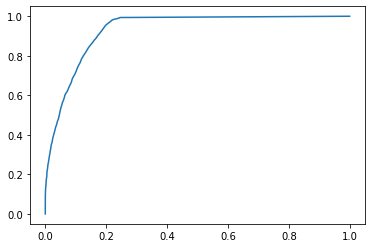

In [36]:
plt.plot(fpr_rfc, tpr_rfc);